In [2]:
from aeon.datasets import load_airline
#!pip install -U aeon
#!pip install aeon[all_extras]
import warnings
import pandas as pd
import numpy as np
from aeon.datasets import load_airline
# from aeon.forecasting.arima import ARIMA
from matplotlib import pyplot as plt
from aeon.forecasting.arima import AutoARIMA
from aeon.forecasting.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from aeon.visualisation import plot_series
from aeon.transformations.detrend import Deseasonalizer
from Statistics_and_Seq2Seq.all_functions import *
warnings.filterwarnings("ignore")
%matplotlib inline
horizon = 12

def mcpm_func(rmse_result, mape_result, pocid_result):
  er_result = 100 - pocid_result

  A1 = (rmse_result * mape_result * np.sin((2*np.pi)/3))/2
  A2 = (mape_result * er_result * np.sin((2*np.pi)/3))/2
  A3 = (er_result * rmse_result * np.sin((2*np.pi)/3))/2
  total = A1 + A2 + A3
  return total

In [3]:
import os

# pastas = [
#           './Statistics_and_Seq2Seq/results/arima/rolling/gasolinac',
#           './Statistics_and_Seq2Seq/results/arima/rolling/oleodiesel',
#           './Statistics_and_Seq2Seq/results/arima/rolling/etanolhidratado',
#           './Statistics_and_Seq2Seq/results/arima/rolling/gasolinadeaviacao',
#           './Statistics_and_Seq2Seq/results/arima/rolling/glp',
#           './Statistics_and_Seq2Seq/results/arima/rolling/oleocombustivel',
#           './Statistics_and_Seq2Seq/results/arima/rolling/querosenedeaviacao',
#           './Statistics_and_Seq2Seq/results/arima/rolling/queroseneiluminante'
#           ]

pastas = [
          './Statistics_and_Seq2Seq/results/varma/rolling/gasolinac',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/oleodiesel',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/etanolhidratado',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/gasolinadeaviacao',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/glp',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/oleocombustivel',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/querosenedeaviacao',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/queroseneiluminante'
          ]


dfs_por_transformacao = {}

for pasta in pastas:
    if os.path.isdir(pasta):
        for arquivo in os.listdir(pasta):
            if arquivo.endswith('.csv'):
                caminho_arquivo = os.path.join(pasta, arquivo)
                df = pd.read_csv(caminho_arquivo, delimiter=';')
                
                for transformacao, grupo in df.groupby('DATA'):
                    if transformacao not in dfs_por_transformacao:
                        dfs_por_transformacao[transformacao] = grupo.copy()
                    else:
                        dfs_por_transformacao[transformacao] = pd.concat(
                            [dfs_por_transformacao[transformacao], grupo], ignore_index=True
                        )


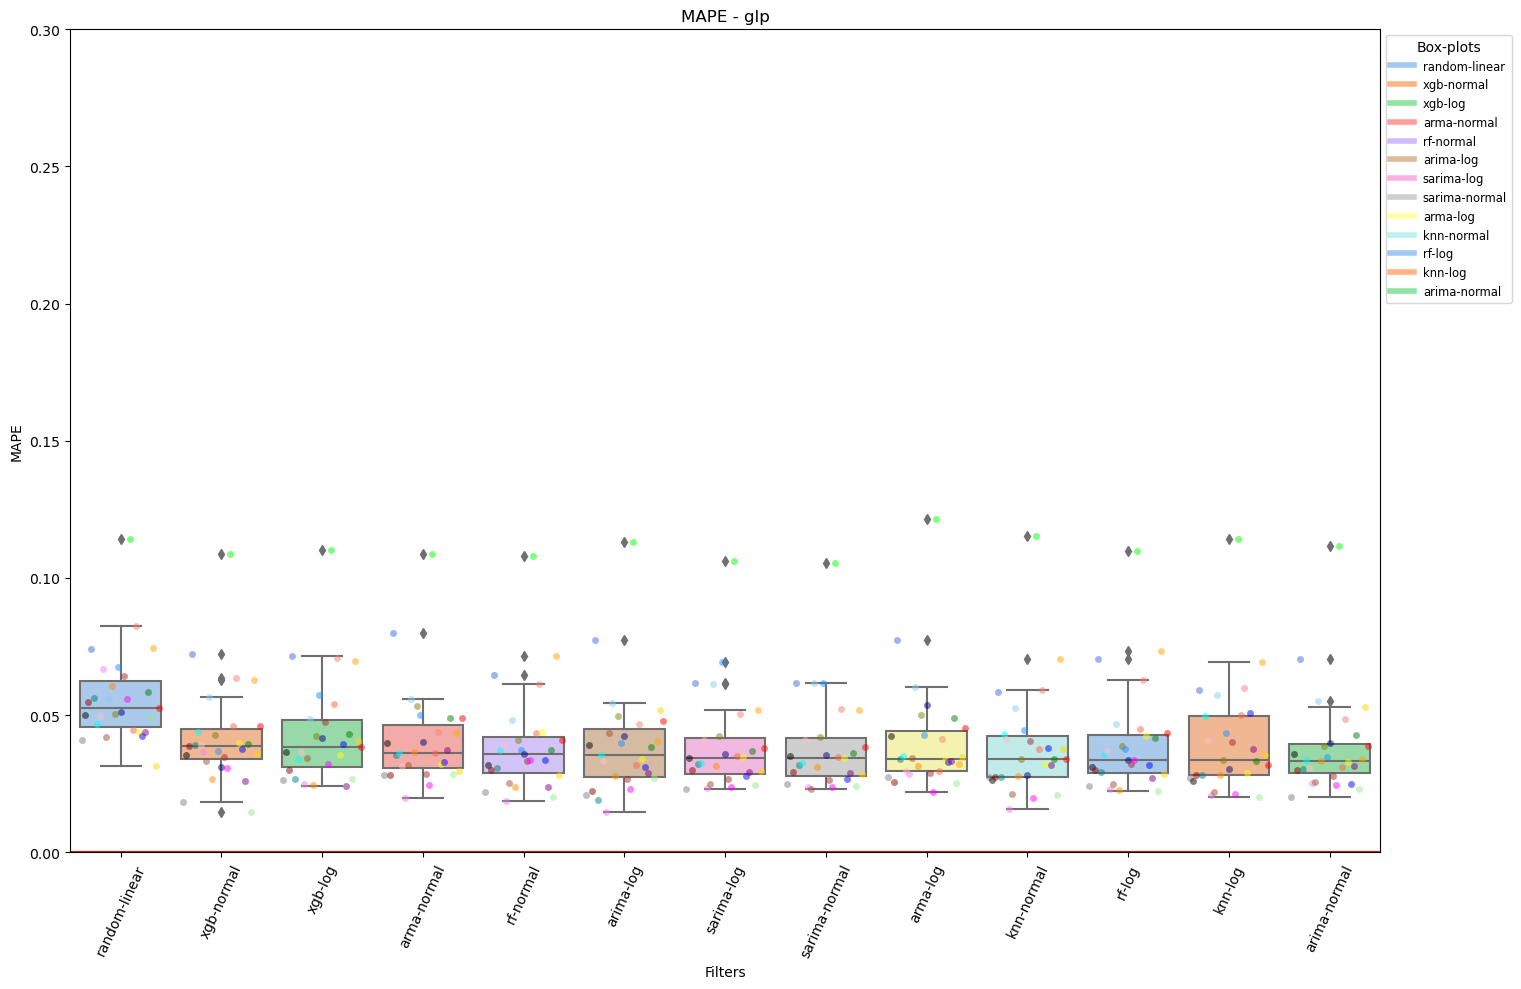

In [18]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

path_data = "./datasets/venda/mensal/uf"
# cores_uf = {
#     'AC': 'green', 'AL': 'green', 'AP': 'green', 'AM': 'green', 'BA': 'green',
#     'CE': 'green', 'DF': 'green', 'ES': 'green', 'GO': 'green', 'MA': 'green',
#     'MT': 'green', 'MS': 'green', 'MG': 'green', 'PA': 'green', 'PB': 'green',
#     'PR': 'blue', 'PE': 'green', 'PI': 'green', 'RJ': 'green', 
#     'RN': 'green', 'RS': 'green', 'RO': 'green', 'RR': 'green', 
#     'SC': 'green', 'SP': 'red', 'SE': 'green', 'TO': 'green'
# }

def safe_eval(preds):
    try:
        # Remover quebras de linha e espaços desnecessários
        preds_clean = preds.replace('\n', ' ').replace('  ', ' ')
        # Remover espaços entre números
        preds_clean = ' '.join(preds_clean.split())
        preds_clean = preds_clean.replace(' ', ',')
        return ast.literal_eval(preds_clean)
    except Exception as e:
        print(f"Erro ao converter: {e}")
        return None
cores_uf = {
    'AC': 'red', 'AL': 'green', 'AP': 'blue', 'AM': 'yellow', 'BA': 'orange',
    'CE': 'purple', 'DF': 'brown', 'ES': 'pink', 'GO': 'gray', 'MA': 'olive',
    'MT': 'cyan', 'MS': 'magenta', 'MG': 'lime', 'PA': 'black', 'PB': 'navy',
    'PR': 'teal', 'PE': 'darkorange', 'PI': 'royalblue', 'RJ': 'salmon', 
    'RN': 'lightgreen', 'RS': 'violet', 'RO': 'gold', 'RR': 'sienna', 
    'SC': 'skyblue', 'SP': 'darkred', 'SE': 'dodgerblue', 'TO': 'tomato'
}

data_test = {}
data_preds = {}
def ler_dados(pastas_filtros):
    dfs_por_transformacao = []
    
    for item in pastas_filtros:
        pasta, filtro_data = item['pasta'], item['filtro']
        if os.path.isdir(pasta):
            for arquivo in os.listdir(pasta):
                if arquivo.endswith('.csv'):
                    derivado = pasta.split("/")[-1]
                    uf = arquivo.split("_")[1][:2]
                    caminho_arquivo = os.path.join(pasta, arquivo)
                    df = pd.read_csv(caminho_arquivo, sep=';')
                    series = read_series(path_data+"/"+derivado+f"/mensal_{uf.lower()}_{derivado}.csv")
                    train, test = train_test_stats(series, horizon)
                    y_baseline = series[-horizon*2:-horizon].values
                    data_test[f'{pasta.split("/")[3]+"-"+filtro_data}_{uf}'] = test
                    df_filtrado = df[df['DATA'] == filtro_data]
                    if 'PREDS' in df_filtrado.columns:
                        predictions = df_filtrado['PREDS'].apply(safe_eval)
                        print(predictions)
                    else:
                        predictions = df_filtrado.loc[:, 'P1':'P12']
                        predictions = predictions.values.flatten().tolist()
                    predictions = pd.Series(predictions, index=test.index)
                    data_preds[f'{pasta.split("/")[3]+"-"+filtro_data}_{uf}'] = predictions
                    # mase_result = mase(test, predictions, y_baseline)
                    # df_filtrado["MASE"] = mase_result
                    df_filtrado['Filtro'] = pasta.split("/")[3]+"-"+filtro_data
                    dfs_por_transformacao.append(df_filtrado)
    
    return pd.concat(dfs_por_transformacao, ignore_index=True)
def gerar_boxplot(df, coluna_metrica, title="-"):
    plt.figure(figsize=(14, 10))
    
    if coluna_metrica == 'POCID':
        quartis = df.groupby('Filtro')[coluna_metrica].quantile(0.75)
        ordenacao_quartil = quartis.sort_values(ascending=False).index
        
        # Usando quartis para ordenação e ajustando a coluna 'Filtro'
        df['Filtro'] = pd.Categorical(df['Filtro'], categories=ordenacao_quartil, ordered=True)
    else:
        medianas = df.groupby('Filtro')[coluna_metrica].median()
        ordenacao_mediana = medianas.sort_values(ascending=False).index
        
        # Usando mediana para ordenação e ajustando a coluna 'Filtro'
        df['Filtro'] = pd.Categorical(df['Filtro'], categories=ordenacao_mediana, ordered=True)

    # Plotando o boxplot e stripplot
    boxplot = sns.boxplot(x='Filtro', y=coluna_metrica, data=df, palette='pastel')
    stripplot = sns.stripplot(x='Filtro', y=coluna_metrica, data=df, palette='pastel', jitter=0.05, alpha=0.5, dodge=True)

    # Configurações adicionais do gráfico
    plt.title(f"{coluna_metrica} - {title}")
    plt.xlabel("Filters")
    plt.ylabel(coluna_metrica)
    plt.xticks(rotation=65)
    plt.tight_layout()

    # Linhas horizontais para MAPE, PBE, POCID
    if coluna_metrica == 'MAPE':
        plt.ylim(0, 0.3)
    elif coluna_metrica == 'PBE':
        plt.ylim(-20, 20)
    elif coluna_metrica == 'POCID':
        plt.ylim(0, 100)
    
    plt.axhline(y=0, color='red', linestyle='-')  # Linha horizontal em zero

    # Determinando a mediana mais próxima
    if coluna_metrica == 'POCID':
        mediana_prox = quartis.median()  # Usando a mediana dos quartis
    else:
        mediana_prox = medianas.median()  # Usando a mediana das medianas
        
    plt.axhline(y=mediana_prox, color='red', linestyle='--')  # Linha pontilhada na mediana mais próxima

    # Legendas personalizadas para os filtros
    colors = sns.color_palette("pastel", len(ordenacao_quartil if coluna_metrica == 'POCID' else ordenacao_mediana))
    filtro_handles = [plt.Line2D([0], [0], color=colors[i], lw=4, label=filtro) for i, filtro in enumerate(ordenacao_quartil if coluna_metrica == 'POCID' else ordenacao_mediana)]
    leg_filtros = plt.legend(handles=filtro_handles, title='Box-plots', bbox_to_anchor=(1, 1), loc='upper left', fontsize='small')
    plt.gca().add_artist(leg_filtros)  # Adiciona a legenda dos filtros novamente

    plt.show()


produto = "glp"
resultado_pasta = 'paper2'
pastas_filtros = [
    #statistics
    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/arima/{produto}', 'filtro': 'normal'},
    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/arima/{produto}', 'filtro': 'log'},

    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/arma/{produto}', 'filtro': 'normal'},
    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/arma/{produto}', 'filtro': 'log'},
    
    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/arima_max_error/{produto}', 'filtro': 'normal'},
    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/arima_max_error/{produto}', 'filtro': 'log'},

    
    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/simple_combination_statistics/{produto}', 'filtro': 'min'},
    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/simple_combination_statistics/{produto}', 'filtro': 'max'},
    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/simple_combination_statistics/{produto}', 'filtro': 'median'},
    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/simple_combination_statistics/{produto}', 'filtro': 'softdtw'},
    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/simple_combination_statistics/{produto}', 'filtro': 'dtw_avg_subgradient'},
    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/simple_combination_statistics/{produto}', 'filtro': 'dtw_avg'},
    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/simple_combination_statistics/{produto}', 'filtro': 'euclidean'},
    # {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/simple_combination_statistics/{produto}', 'filtro': 'twe'},

 
  

    {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/knn/{produto}', 'filtro': 'normal'},
    {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/knn/{produto}', 'filtro': 'log'},
    {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/rf/{produto}', 'filtro': 'normal'},
    {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/rf/{produto}', 'filtro': 'log'},
    {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/xgb/{produto}', 'filtro': 'normal'},
    {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/xgb/{produto}', 'filtro': 'log'},


    {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/arima/{produto}', 'filtro': 'normal'},
    {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/arima/{produto}', 'filtro': 'log'},
    {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/arma/{produto}', 'filtro': 'normal'},
    {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/arma/{produto}', 'filtro': 'log'},
    {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/sarima/{produto}', 'filtro': 'normal'},
    {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/sarima/{produto}', 'filtro': 'log'},

    {'pasta': f'./Statistics_and_Seq2Seq/{resultado_pasta}/random/{produto}', 'filtro': 'linear'},
    
]
coluna_metrica = "MAPE"  #"MCPM", "PBE", "RMSE", "POCID" ou "MAPE"

df_consolidado = ler_dados(pastas_filtros)

gerar_boxplot(df_consolidado, coluna_metrica, title=produto)


In [5]:
# caminho_paper = './Statistics_and_Seq2Seq/paper2/knn'
# horizon = 12  # Defina o valor de horizon conforme necessário

# def get_predictions_csv(path, format, start_index):
#     df = pd.read_csv(path, sep=";")
#     results = {}
#     params = {}
#     # for format in formats:
#     filtered_df = df[df['DATA'] == format]
    
#     columns_p1_to_p12 = filtered_df.loc[:, 'P1':'P12']
    
#     # values_list = columns_p1_to_p12.values.tolist()
#     values_list = columns_p1_to_p12.values.flatten().tolist()     
#     results = pd.Series(values_list, index=start_index)
#     params = filtered_df['PARAMS'].iloc[0]
            
#     return results, params

# for subdir, _, files in os.walk(caminho_paper):
#     for file in files:
#         if file.endswith('.csv'):
#             uf = file.split("_")[1][:2]
#             derivado = subdir.split("/")[-1]
#             path_derivado = caminho_paper + f"/{derivado}"
#             series = read_series(f"./datasets/venda/mensal/uf/{derivado}/mensal_{uf.lower()}_{derivado}.csv")
#             _, test = train_test_stats(series, horizon)

#             for tf in ["normal", "log"]:
#                 preds, params = get_predictions_csv(f"{caminho_paper}/{derivado}/transform_{uf}.csv", tf, start_index=test.index)
#                 csv_file = path_derivado + f"/transform_{uf.upper()}.csv"
#                 df_file = pd.read_csv(csv_file, sep=";")
#                 df_file.loc[df_file['DATA'] == tf, 'POCID'] = pocid(test, preds)
#                 df_file.to_csv(csv_file, sep=';', index=False)